## LLM

In [1]:
import torch as torch
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import Transformer
from src.optimization import train_step, forward_and_loss, group_decay_parameters, save_checkpoint, load_checkpoint
from src.utils import saver, loader
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 
print("cuda available:", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701
cuda available: True


## Load Data

In [2]:
tokenizer = loader("tokenizers/cnn_tokenizer.pkl")

In [3]:
corpus_train1 = torch.tensor(loader("corpus/cnn_dailymail_article_train_tokens1.pkl"))
corpus_train2 = torch.tensor(loader("corpus/cnn_dailymail_article_train_tokens2.pkl"))
corpus_train3 = torch.tensor(loader("corpus/cnn_dailymail_article_train_tokens3.pkl"))
corpus_train4 = torch.tensor(loader("corpus/cnn_dailymail_article_train_tokens4.pkl"))
corpus_train_a = torch.cat((corpus_train1, corpus_train2, corpus_train3, corpus_train4), dim=0)

corpus_train1 = torch.tensor(loader("corpus/cnn_dailymail_HLlast_train_tokens1.pkl"))
corpus_train2 = torch.tensor(loader("corpus/cnn_dailymail_HLlast_train_tokens2.pkl"))
corpus_train3 = torch.tensor(loader("corpus/cnn_dailymail_HLlast_train_tokens3.pkl"))
corpus_train4 = torch.tensor(loader("corpus/cnn_dailymail_HLlast_train_tokens4.pkl"))
corpus_train_b = torch.cat((corpus_train1, corpus_train2, corpus_train3, corpus_train4), dim=0)

corpus_train = torch.cat((corpus_train_a, corpus_train_b), dim=0)

corpus_test_a = torch.tensor(loader("corpus/cnn_dailymail_article_test_tokens.pkl"))
corpus_test_b = torch.tensor(loader("corpus/cnn_dailymail_HLlast_test_tokens.pkl"))
corpus_test = torch.cat((corpus_test_a, corpus_test_b), dim=0)

In [4]:
def batch_data(corpus, batch_length=1024, offset=None):
    """
    Splits the corpus into batches of size batch_size.
    """
    length = len(corpus)
    batches = length // batch_length
    corpus_truncated = corpus[:batches * batch_length]  # trim to a multiple of batch_length
    corpus_batched = corpus_truncated.view(-1, batch_length)  # reshape into batches

    # overlapping batches augmentation
    if offset is not None:
        corpus_offset = corpus_truncated[offset : offset - batch_length]
        corpus_offset = corpus_offset.view(-1, batch_length)  # reshape into batches
        corpus_batched = torch.cat((corpus_batched, corpus_offset), dim=0)  # concatenate the offset batches

    return corpus_batched

In [5]:
corpus_train_batched = batch_data(corpus_train, batch_length=1024, offset=None)
corpus_test_batched = batch_data(corpus_test, batch_length=1024, offset=None)

In [6]:
loader_train = DataLoader(
    corpus_train_batched,
    batch_size=3,
    shuffle=True,       # shuffle every epoch
    drop_last=True      # drop the last incomplete batch
)

loader_test = DataLoader(
    corpus_test_batched,
    batch_size=3,
    shuffle=True,      # no need to shuffle test data
    drop_last=True      # drop the last incomplete batch
)

## Initialize Model

In [7]:
torch.manual_seed(42)

embed_dim = 64*18
ff_dim = 4*embed_dim
heads = 18
tf_blocks = 18

model = Transformer(
    embed_dim=embed_dim,
    ff_dim=ff_dim,
    heads=heads,
    tf_blocks=tf_blocks,
    vocab_size=tokenizer.vocab_size,
    max_seq_len=1024,
    dropout=0.1,
    start_token_id=tokenizer.token_to_idx["<s>"],
    use_weight_tying=True
).to(device)

optimizer_grouped_parameters = group_decay_parameters(
    model,
    weight_decay=0.1,
    no_decay=["bias", "LayerNorm.weight"],
    )

loss_train_list = []
loss_eval_list = []

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
scaler = torch.amp.GradScaler("cuda")

num_epochs      = 1
steps_per_epoch = len(loader_train)
warmup_steps    = 1000

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Load Model

In [9]:
model, optimizer, scheduler = load_checkpoint("checkpoint_transformer.pth", model, optimizer, scheduler)
loss_train_list = loader("loss_train.pkl")
loss_eval_list = loader("loss_eval.pkl")

In [10]:
optimizer.zero_grad()
model.train()
device = next(model.parameters()).device
accum_steps = 80

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for step, batch in enumerate(tqdm(loader_train, desc="Training")):
        batch = batch.to(device)
        loss_train = train_step(model, 
                          batch, 
                          criterion, 
                          optimizer, 
                          scaler, 
                          scheduler, 
                          accum_steps,
                          step).item()
        if (step+1) % 500 == 0:
            model.eval()
            lr = scheduler.get_last_lr()[0]
            iter_test = iter(loader_test)
            with torch.no_grad():
                loss_eval = np.mean([forward_and_loss(model, next(iter_test).to(device), criterion).item() for _ in range(accum_steps)])
                print(f"Step {step+1}, Loss: {loss_train:<.4f}, Loss_eval: {loss_eval:<.4f}, Learning Rate: {lr:4e}")

            loss_train_list.append(loss_train)
            loss_eval_list.append(loss_eval)

            model.train()

        if (step+1) % 5000 == 0:
            save_checkpoint(model, 
                            optimizer, 
                            scheduler, 
                            filename="checkpoint_transformer.pth")
            saver("loss_train.pkl", loss_train_list)
            saver("loss_eval.pkl", loss_eval_list)
            
    save_checkpoint(model, 
                    optimizer, 
                    scheduler, 
                    filename="checkpoint_transformer.pth")
    saver("loss_train.pkl", loss_train_list)
    saver("loss_eval.pkl", loss_eval_list)


Epoch 1/1


Training:   0%|          | 0/175316 [00:00<?, ?it/s]

Step 500, Loss: 3.0101, Loss_eval: 3.3781, Learning Rate: 5.000000e-05
Step 1000, Loss: 3.1362, Loss_eval: 3.3859, Learning Rate: 5.000000e-05
Step 1500, Loss: 3.1878, Loss_eval: 3.3847, Learning Rate: 5.000000e-05
Step 2000, Loss: 3.1127, Loss_eval: 3.3824, Learning Rate: 5.000000e-05
Step 2500, Loss: 2.9768, Loss_eval: 3.3939, Learning Rate: 5.000000e-05
Step 3000, Loss: 2.9542, Loss_eval: 3.3924, Learning Rate: 5.000000e-05
Step 3500, Loss: 2.8370, Loss_eval: 3.3782, Learning Rate: 5.000000e-05
Step 4000, Loss: 3.2016, Loss_eval: 3.3700, Learning Rate: 5.000000e-05
Step 4500, Loss: 3.1186, Loss_eval: 3.3971, Learning Rate: 5.000000e-05
Step 5000, Loss: 3.2227, Loss_eval: 3.3826, Learning Rate: 5.000000e-05
Step 5500, Loss: 3.1356, Loss_eval: 3.3757, Learning Rate: 5.000000e-05
Step 6000, Loss: 3.2055, Loss_eval: 3.3679, Learning Rate: 5.000000e-05
Step 6500, Loss: 3.1512, Loss_eval: 3.3647, Learning Rate: 5.000000e-05
Step 7000, Loss: 3.0872, Loss_eval: 3.3687, Learning Rate: 5.0000

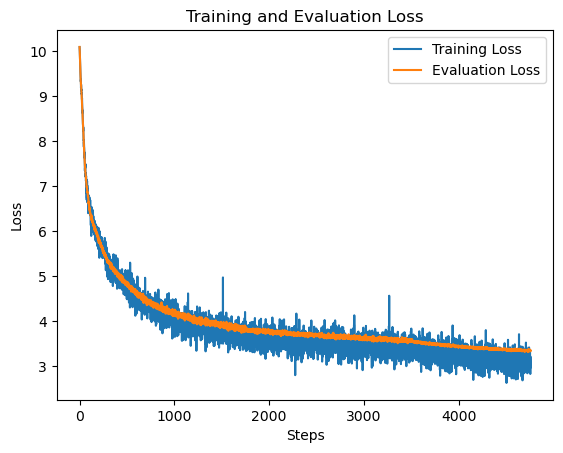

In [15]:
plt.plot(loss_train_list)
plt.plot(loss_eval_list)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend(["Training Loss", "Evaluation Loss"])
plt.show()
